In [138]:
require 'nn'
require 'image' --necessary?
require("lfwMCMCUpdatesFunction")
require("lfwCDBNModelBuilderFunction")
-- spatialConvolution only seems to be able to process one image ata ie (i.e. expects a 3D tensor only)
-- Constant step size for hiddenBias updates?

In [137]:
package.loaded["lfwMCMCUpdatesFunction"] = nil

In [139]:
model = CDBNModelBuilder(2,{3,3},{32,64},{10,10})

In [3]:
testReadFile = torch.DiskFile('lfwDataSetShort.foo', 'r')
testRead = testReadFile:readObject()

In [4]:
trainingData = image.scale(testRead[{{1,20},{},{}}],100,100)
--collectgarbage("count")

In [141]:
index = 1
--baseLayer = trainingData[{{1},{},{}}]
--model:forward(baseLayer)
--visLayer = model:get(6).output
visLayer = trainingData[{{1},{},{}}]

In [140]:
--model

In [128]:
--model:get(1).output

In [142]:

learningRate = {0.0001,0.01,0.001} --hiddenBias learningRate fine, others a little too high - convergence issues.
sparsityPenalty=0.03125
convergenceThreshold = 0.001

In [143]:
    
    --variable setup---
    convergenceFlag = 0
    repeatCounter = 0
    --predeclaring the memory to be used.
    --hiddenTensor = torch.Tensor(model:get(index).output:size())
    hiddenTensor = model:get(index):forward(visLayer)
    origHiddenTensorClone = hiddenTensor:clone()
    probTensor = torch.Tensor(hiddenTensor:size())
    --so that we don't interfere with memory outside of the function we will create a clone of the visLayer
    visLayerClone = torch.Tensor(visLayer:size())
    --Nh,K,Vl,Nw,Nv,visBias
    K = hiddenTensor:size()[1]
    Vl = visLayer:size()[1]
    visBias = torch.Tensor(Vl):fill(0)
    Nh = hiddenTensor:size()[2]
    Nv = visLayer:size()[2]
    Nw = model:get(index).weight:size()[3]
    --/variable setup---
    
    --INITIALISATION STEP. --Here we will need to initialise the filters using the K-Means/Gaussian EM thing.
    filterWeights = model:get(index).weight
    hiddenBias = model:get(index).bias --Note that these create a reference, not a clone, so altering
        --either filterWeights or hiddenBias will also alter the model's parameters too.
    --/INITIALISATION STEP.
    
    --PRECALLING OF FUNCTIONS---
    --gradFilterConv will be used in the parameter updates step, specifically to update the filters. Since
    --  the weight is tied to the hiddenTensor and NOT CLONED we should be able to update the convolution
    --  without having to constantly redeclare the convolution
    gradFilterConv = nn.SpatialConvolution(1,K,Nh,Nh)
    gradFilterConv.bias = torch.Tensor(K):fill(0)
    gradFilterConv.weight[{{},{1},{},{}}] = hiddenTensor
    
    --origSampleFilterWeightDifferential used as the base from which the filter weights CD gradient is 
    --    approximated; the summation convolution with the original training data sample
    origSampleFilterWeightDifferential = torch.Tensor(Vl,K,Nw,Nw) --??? Should work hopefully ???
    for l = 1,Vl do
        origSampleFilterWeightDifferential[l] = gradFilterConv:forward(visLayer[{{l},{},{}}]) --???? Hope this works
    end
    --/PRECALLING OF FUNCTIONS---

In [144]:
filterWeightBase = filterWeights:clone()
        hBBase = hiddenBias:clone()
        vBBase = visBias:clone()

In [145]:
   
    while (repeatCounter < 1000 and convergenceFlag == 0) do
        repeatCounter = repeatCounter + 1
        print(repeatCounter)
        --*********************************************************************
        --switch visible image being considered -- REJIG HIDDEN TENSOR STUFF.
        --*********************************************************************
        
        --MCMC UPDATES STEP - can expand this for CD-k, but for the moment just using CD-1
        --gibbsHiddenUpdate
        hiddenTensor = origHiddenTensorClone:clone()
        hiddenTensor, probTensor =  gibbsHiddenUpdate(Nh,K,Nw,hiddenTensor)

        if index == 1 then
            -- Real Visible Layer 
            visLayerClone = gibbsRealVisibleUpdate(model,index,Nv,K,Vl,Nw,visBias,hiddenTensor)
        
        else 
            -- Binary Visible Layer
            visLayerClone = gibbsBinaryVisibleUpdate(model,index,Nv,K,Vl,Nw,visBias,hiddenTensor)
            
        end
        --/MCMC UPDATES STEP.
        
        --Update weights and biases using the CD approximation---
        --learningRate will pop up here
        
        fWCopy = filterWeights:clone()
        hBCopy = hiddenBias:clone()
        vBCopy = visBias:clone()

        --filter weight updates
        newSampleFWDiff = torch.Tensor(Vl,K,Nw,Nw)
        for l = 1,Vl do 
          newSampleFWDiff[l] = gradFilterConv:forward(visLayerClone[{{l},{},{}}]) 
        end
        filterWeights:add(learningRate[1]/(Nh*Nh),origSampleFilterWeightDifferential:add(-1,newSampleFWDiff)) 
        
        --hidden Bias Updates
        --  Without Sparsity
        --hiddenBias:add(learningRate,origHiddenTensorClone:sum(2):sum(3):add(-1,origHiddenTensorClone:sum(2):sum(3)))
        --  With Sparsity
        hiddenBias:add(learningRate[2]/(Nh*Nh),origHiddenTensorClone:sum(2):sum(3):add(-1,origHiddenTensorClone:sum(2):sum(3)))
        
        --uses the probTensor in 
        sparsityPenaltyAddition = torch.Tensor(K):fill(sparsityPenalty):add(-1/(Nh*Nh),probTensor:sum(2):sum(3))        
        hiddenBias:add(learningRate[2],sparsityPenaltyAddition)
        
        --visible Bias Updates
        visBias:add(learningRate[3]/(Nv*Nv),  visLayer:sum(2):sum(3):add(-1,visLayerClone:sum(2):sum(3))   )
        
        --/Update weights and biases using the CD approximation---
        
        if(torch.dist(visBias,vBCopy)+torch.dist(hiddenBias,hBCopy)+torch.dist(fWCopy,filterWeights) < convergenceThreshold ) then 
            convergenceFlag = 1
        end
        --calculate convergenceDistance and see whether to terminate process or keep going.
collectgarbage("collect")
        if(repeatCounter%10 == 0) then
            print(torch.dist(visBias,vBCopy))
            print(torch.dist(hiddenBias,hBCopy))
            print(torch.dist(fWCopy,filterWeights))
                --calculate convergenceDistance and see whether to terminate process or keep going.
            print(collectgarbage("count") .." MegaBytes used" )
        end
    end

1	


2	


3	


4	


5	


6	


7	


8	


9	


10	


6.5932811077493e-05	
0.0011050029267834	
0.0029923489989334	
1507.3037109375 MegaBytes used	
11	


12	


13	


14	


15	


16	


17	


18	


19	


20	


6.7189524406057e-05	
0.0011050029267834	
0.0064581780750471	
1507.3037109375 MegaBytes used	
21	


22	


23	


24	


25	


26	


27	


28	


29	


30	


6.043512896449e-05	
0.0011050029267834	
0.009914145845342	
1507.2998046875 MegaBytes used	
31	


32	


33	


34	


35	


36	


37	


38	


39	


40	


6.3633624200973e-05	
0.0011050029267834	
0.013349280098738	
1507.3017578125 MegaBytes used	
41	


42	


43	


44	


45	


46	


47	


48	


49	


50	


6.3642918554588e-05	
0.0011050029267834	
0.016758774206964	
1507.3017578125 MegaBytes used	
51	


52	


53	


54	


55	


56	


57	


58	


59	


60	


6.4527515487242e-05	
0.0011050029267834	
0.020186997571281	
1507.3017578125 MegaBytes used	
61	


62	


63	


64	


65	


66	


67	


68	


69	


70	


6.4506730902678e-05	
0.0011050029267834	
0.023551470475124	
1507.3017578125 MegaBytes used	
71	


72	


73	


74	


75	


76	


77	


78	


79	


80	


4.7804829828279e-05	
0.0011050029267834	
0.026869542609469	
1507.3017578125 MegaBytes used	
81	


82	


83	


84	


85	


86	


87	


88	


89	


90	


5.6777427266262e-05	
0.0011050029267834	
0.030169167377755	
1507.3017578125 MegaBytes used	
91	


92	


93	


94	


95	


96	


97	


98	


99	


100	


4.8533329049704e-05	
0.0011050029267834	
0.033447854974554	
1507.3017578125 MegaBytes used	
101	


102	


103	


104	


105	


106	


107	


108	


109	


110	


3.1582880648715e-05	
0.0011050029267834	
0.036680957422035	
1507.3017578125 MegaBytes used	
111	


112	


113	


114	


115	


116	


117	


118	


119	


120	


4.2606984296407e-05	
0.0011050029267834	
0.039912725147493	
1507.3017578125 MegaBytes used	
121	


122	


123	


124	


125	


126	


127	


128	


129	


130	


3.9958529143789e-05	
0.0011050029267834	


0.043095362728776	
1507.3017578125 MegaBytes used	
131	


132	


133	


134	


135	


136	


137	


138	


139	


140	


4.4418010920696e-05	
0.0011050029267834	
0.04626050492101	
1507.2998046875 MegaBytes used	
141	


142	


143	


144	


145	


146	


147	


148	


149	


150	


5.4218559317309e-05	
0.0011050029267834	
0.049363740224425	
1507.3017578125 MegaBytes used	
151	


152	


153	


154	


155	


156	


157	


158	


159	


160	


2.5387382762662e-05	
0.0011050029267834	
0.052453627842846	
1507.3017578125 MegaBytes used	
161	


162	


163	


164	


165	


166	


167	


168	


169	


170	


4.809687564861e-05	
0.0011050029267834	
0.055528812129442	
1507.2998046875 MegaBytes used	
171	


172	


173	


174	


175	


176	


177	


178	


179	


180	


2.3432838407576e-05	
0.0011050029267834	
0.058509374261173	
1507.3017578125 MegaBytes used	
181	


182	


183	


184	


185	


186	


187	


188	


189	


190	


3.6771241675081e-05	
0.0011050029267834	
0.061485471332563	
1507.3017578125 MegaBytes used	
191	


192	


193	


194	


195	


196	


197	


198	


199	


200	


4.3042487926843e-05	
0.0011050029267834	
0.064580442875769	
1507.3017578125 MegaBytes used	
201	


202	


203	


204	


205	


206	


207	


208	


209	


210	


5.6491762766354e-05	
0.0011050029267834	
0.067550784167995	
1507.3017578125 MegaBytes used	
211	


212	


213	


214	


215	


216	


217	


218	


219	


220	


4.8359544482271e-05	
0.0011050029267834	
0.070558565436616	
1507.3017578125 MegaBytes used	
221	


222	


223	


224	


225	


226	


227	


228	


229	


230	


5.4989883423239e-05	
0.0011050029267834	


0.073606595340601	
1507.3017578125 MegaBytes used	
231	


232	


233	


234	


235	


236	


237	


238	


239	


240	


3.0251575339025e-05	
0.0011050029267834	
0.076615797879149	
1507.3017578125 MegaBytes used	
241	


242	


243	


244	


245	


246	


247	


248	


249	


250	


4.9947018315663e-05	
0.0011050029267834	
0.079582597882032	
1507.3017578125 MegaBytes used	
251	


252	


253	


254	


255	


256	


257	


258	


259	


260	


6.4608041564357e-06	
0.0011050029267834	
0.08253842326811	
1507.2998046875 MegaBytes used	
261	


262	


263	


264	


265	


266	


267	


268	


269	


270	


2.7211694660025e-05	
0.0011050029267834	
0.085738038344864	
1507.3017578125 MegaBytes used	
271	


272	


273	


274	


275	


276	


277	


278	


279	


280	


7.2728426986357e-06	
0.0011050029267834	


0.088598744673075	
1507.3017578125 MegaBytes used	
281	


282	


283	


284	


285	


286	


287	


288	


289	


290	


4.5329963546793e-05	
0.0011050029267834	
0.09174106376858	
1507.2998046875 MegaBytes used	
291	


292	


293	


294	


295	


296	


297	


298	


299	


300	


4.0811973261815e-05	
0.0011050029267834	


0.09492475221594	
1507.2998046875 MegaBytes used	
301	


302	


303	


304	


305	


306	


307	


308	


309	


310	


2.4382904857879e-05	
0.0011050029267834	
0.098134633290507	
1507.3017578125 MegaBytes used	
311	


312	


313	


314	


315	


316	


317	


318	


319	


320	


7.3825933094405e-05	
0.0011050029267834	
0.10124689696539	
1507.2998046875 MegaBytes used	
321	


322	


323	


324	


325	


326	


327	


328	


329	


330	


1.9468243010393e-05	
0.0011050029267834	
0.10398846457786	
1507.2998046875 MegaBytes used	
331	


332	


333	


334	


335	


336	


337	


338	


339	


340	


8.9825657057422e-05	
0.0011050029267834	
0.10730676436081	
1507.2998046875 MegaBytes used	
341	


342	


343	


344	


345	


346	


347	


348	


349	


350	


6.6029869409796e-05	
0.0011050029267834	
0.11061748383526	
1507.2998046875 MegaBytes used	
351	


352	


353	


354	


355	


356	


357	


358	


359	


360	


6.0371691874551e-05	
0.0011050029267834	
0.11379858394583	
1507.2998046875 MegaBytes used	
361	


362	


363	


364	


365	


366	


367	


368	


369	


370	


4.3974209080654e-05	
0.0011050029267834	
0.11683698147969	
1507.2998046875 MegaBytes used	
371	


372	


373	


374	


375	


376	


377	


378	


379	


380	


0.00012199040067159	
0.0011050029267834	
0.12025661660272	
1507.2998046875 MegaBytes used	
381	


382	


383	


384	


385	


386	


387	


388	


389	


390	


5.4099050557976e-05	
0.0011050029267834	
0.12371696891673	
1507.2998046875 MegaBytes used	
391	


392	


393	


394	


395	


396	


397	


398	


399	


400	


6.1118935293272e-05	
0.0011050029267834	
0.12713868894257	
1507.2998046875 MegaBytes used	
401	


402	


403	


404	


405	


406	


407	


408	


409	


410	


2.4558282502616e-05	
0.0011050029267834	
0.13050344995232	
1507.2998046875 MegaBytes used	
411	


412	


413	


414	


415	


416	


417	


418	


419	


420	


8.1729614280185e-05	
0.0011050029267834	
0.13405852960512	
1507.2998046875 MegaBytes used	
421	


422	


423	


424	


425	


426	


427	


428	


429	


430	


4.8677661116898e-05	


0.0011050029267834	
0.13745768394098	
1507.2998046875 MegaBytes used	
431	


432	


433	


434	


435	


436	


437	


438	


439	


440	


2.5070012456451e-05	
0.0011050029267834	
0.14070978702391	
1507.2998046875 MegaBytes used	
441	


442	


443	


444	


445	


446	


447	


448	


449	


450	


0.00012778646799793	
0.0011050029267834	
0.14416295089252	
1507.2998046875 MegaBytes used	
451	


452	


453	


454	


455	


456	


457	


458	


459	


460	


0.00012107143301211	
0.0011050029267834	
0.14772488695254	
1507.2998046875 MegaBytes used	
461	


462	


463	


464	


465	


466	


467	


468	


469	


470	


4.2007757163297e-05	
0.0011050029267834	


0.15119016270593	
1507.2998046875 MegaBytes used	
471	


472	


473	


474	


475	


476	


477	


478	


479	


480	


6.1964161462189e-05	
0.0011050029267834	
0.15472666917847	
1507.2998046875 MegaBytes used	
481	


482	


483	


484	


485	


486	


487	


488	


489	


490	


6.4539547417565e-05	
0.0011050029267834	
0.15813657878516	
1507.2998046875 MegaBytes used	
491	


492	


493	


494	


495	


496	


497	


498	


499	

500	


0.00014199917312837	
0.0011050029267834	
0.16189919966067	
1507.2998046875 MegaBytes used	
501	


502	


503	


504	


505	


506	


507	


508	


509	


510	


6.0323119332972e-05	
0.0011050029267834	
0.16530955015552	
1507.2998046875 MegaBytes used	
511	


512	


513	


514	

515	


516	


517	


518	


519	


520	


8.540419352673e-05	
0.0011050029267834	
0.16869725588528	
1507.2978515625 MegaBytes used	


521	


522	


523	


524	


525	


526	


527	


528	


529	


530	


7.3884745449972e-05	
0.0011050029267834	
0.17219443146447	
1507.2998046875 MegaBytes used	
531	


532	


533	


534	


535	


536	


537	


538	


539	


540	


0.00013619314386609	
0.0011050029267834	
0.17569393860319	
1507.2998046875 MegaBytes used	
541	


542	


543	


544	


545	


546	


547	


548	


549	


550	


0.00014309177730751	
0.0011050029267834	
0.17931754513977	
1507.2998046875 MegaBytes used	
551	


552	


553	


554	


555	


556	


557	


558	


559	


560	


8.1530783355481e-05	
0.0011050029267834	
0.18290173795252	
1507.2998046875 MegaBytes used	
561	


562	


563	


564	


565	


566	


567	


568	


569	


570	


0.00017148234702917	
0.0011050029267834	
0.18644446294265	
1507.2998046875 MegaBytes used	
571	


572	


573	


574	


575	


576	


577	


578	


579	


580	


8.1812197879706e-05	
0.0011050029267834	
0.19020704439344	
1507.2998046875 MegaBytes used	
581	


582	


583	


584	


585	


586	


587	


588	


589	


590	


9.8223980126988e-05	
0.0011050029267834	
0.19377854628991	
1507.2998046875 MegaBytes used	
591	


592	


593	


594	


595	

596	


597	


598	


599	


600	


4.4972137261387e-05	
0.0011050029267834	


0.19734113576934	
1507.2998046875 MegaBytes used	
601	


602	


603	


604	


605	


606	


607	


608	


609	


610	


5.1395505765682e-05	
0.0011050029267834	
0.20088999179614	
1507.2998046875 MegaBytes used	
611	


612	


613	


614	


615	


616	


617	


618	


619	


620	


0.00012419762052343	
0.0011050029267834	
0.20455314562318	
1507.2998046875 MegaBytes used	
621	


622	


623	


624	


625	


626	


627	


628	


629	


630	


5.2991628563405e-05	
0.0011050029267834	
0.20793787135514	
1507.2998046875 MegaBytes used	
631	


632	


633	


634	


635	


636	


637	


638	


639	


640	


1.7609451379956e-05	
0.0011050029267834	


0.21152167437037	
1507.2998046875 MegaBytes used	
641	


642	


643	


644	


645	


646	


647	


648	


649	


650	


6.5130862257207e-05	
0.0011050029267834	


0.21503884624884	
1507.2998046875 MegaBytes used	
651	


652	


653	


654	


655	


656	


657	


658	


659	


660	


7.8295323856364e-05	
0.0011050029267834	
0.21877449031344	
1507.2998046875 MegaBytes used	
661	


662	


663	


664	


665	


666	


667	


668	


669	


670	


7.5238030532207e-05	
0.0011050029267834	
0.22232338110491	
1507.2998046875 MegaBytes used	
671	


672	


673	


674	


675	


676	


677	


678	


679	


680	


0.000138656525523	
0.0011050029267834	
0.2263058114722	
1507.2939453125 MegaBytes used	
681	


682	


683	


684	


685	


686	


687	


688	


689	


690	


0.0001242425763916	
0.0011050029267834	
0.22976554661451	
1507.2978515625 MegaBytes used	
691	


692	


693	


694	


695	


696	


697	


698	


699	


700	


7.2276389393083e-05	
0.0011050029267834	
0.23355397783463	
1507.2998046875 MegaBytes used	
701	


702	


703	


704	


705	


706	


707	


708	


709	


710	


0.00010710395816173	
0.0011050029267834	
0.23716194555737	
1507.2998046875 MegaBytes used	
711	


712	


713	


714	


715	


716	


717	


718	


719	


720	


0.00013277852487541	
0.0011050029267834	
0.24075527799043	
1507.2998046875 MegaBytes used	
721	


722	


723	


724	


725	


726	


727	


728	


729	


730	


0.00012718172371477	
0.0011050029267834	


0.24426760185436	
1507.2998046875 MegaBytes used	
731	


732	


733	


734	


735	


736	


737	


738	


739	


740	


9.4414746093785e-05	
0.0011050029267834	
0.2480672836949	
1507.2978515625 MegaBytes used	
741	


742	


743	


744	


745	


746	


747	


748	

749	


750	


8.0925148053572e-05	
0.0011050029267834	
0.25192772622932	
1507.2998046875 MegaBytes used	
751	


752	


753	


754	


755	


756	


757	


758	


759	


760	


0.00014352994560271	
0.0011050029267834	
0.25556584353237	
1507.2998046875 MegaBytes used	
761	


762	


763	


764	


765	


766	


767	


768	


769	


770	


0.00013525599849448	
0.0011050029267834	


0.25912497432642	
1507.2998046875 MegaBytes used	
771	


772	


773	


774	


775	


776	


777	


778	


779	


780	


0.00017574789311686	
0.0011050029267834	
0.26307338412714	
1507.2998046875 MegaBytes used	
781	


782	


783	


784	


785	


786	


787	


788	


789	


790	


4.2524545844011e-05	
0.0011050029267834	
0.26672499652062	
1507.2998046875 MegaBytes used	
791	


792	


793	


794	


795	


796	


797	


798	


799	


800	


9.2196322833117e-05	
0.0011050029267834	
0.27042545104003	
1507.2998046875 MegaBytes used	
801	


802	


803	


804	


805	


806	


807	


808	


809	


810	


5.8453199033678e-05	
0.0011050029267834	
0.27418029270781	
1507.2998046875 MegaBytes used	
811	


812	


813	


814	


815	


816	


817	


818	


819	


820	


0.00016095539389677	
0.0011050029267834	
0.27802389584242	
1507.2998046875 MegaBytes used	
821	


822	


823	


824	


825	


826	


827	


828	


829	

830	


8.0605580793904e-05	
0.0011050029267834	
0.28164166822947	
1507.2998046875 MegaBytes used	
831	


832	


833	


834	


835	


836	


837	


838	


839	


840	


8.6771876247525e-05	
0.0011050029267834	
0.28516376397627	
1507.2998046875 MegaBytes used	
841	


842	


843	


844	


845	


846	


847	


848	


849	


850	


0.00010844513939048	
0.0011050029267834	
0.28899277125656	
1507.2998046875 MegaBytes used	
851	


852	


853	


854	


855	


856	


857	


858	


859	


860	


6.3139906114895e-05	
0.0011050029267834	
0.29264576146009	
1507.2998046875 MegaBytes used	
861	


862	


863	


864	


865	


866	


867	


868	


869	


870	


0.00011451480499616	
0.0011050029267834	
0.29643994615035	
1507.2998046875 MegaBytes used	
871	


872	


873	


874	


875	

876	


877	


878	


879	


880	


9.0241888051096e-05	
0.0011050029267834	
0.30034511830828	
1507.2998046875 MegaBytes used	
881	


882	


883	


884	


885	


886	


887	


888	


889	


890	


0.00011680677859881	
0.0011050029267834	
0.30440945291861	
1507.2998046875 MegaBytes used	
891	


892	


893	


894	


895	


896	


897	


898	


899	


900	


5.7925998830699e-05	
0.0011050029267834	
0.30806498041495	
1507.2998046875 MegaBytes used	
901	


902	


903	


904	


905	


906	


907	


908	


909	


910	


0.00011064639734916	
0.0011050029267834	
0.31183019543618	
1507.2998046875 MegaBytes used	
911	


912	


913	


914	


915	


916	


917	


918	


919	


920	


2.2821759013858e-05	
0.0011050029267834	
0.31582265434027	
1507.2998046875 MegaBytes used	
921	


922	


923	


924	


925	


926	


927	


928	


929	


930	


9.3432781114525e-05	
0.0011050029267834	
0.3194569070228	
1507.2978515625 MegaBytes used	
931	


932	


933	


934	


935	


936	


937	


938	


939	


940	


0.00019929205034011	
0.0011050029267834	
0.32356807181898	
1507.2998046875 MegaBytes used	
941	


942	


943	


944	


945	


946	


947	


948	


949	


950	


6.050848211428e-05	
0.0011050029267834	
0.32735981425544	
1507.2978515625 MegaBytes used	
951	


952	


953	


954	


955	


956	


957	


958	


959	


960	


0.00018817575546036	
0.0011050029267834	
0.33127906551943	
1507.2998046875 MegaBytes used	
961	


962	


963	


964	


965	


966	


967	


968	


969	


970	


0.00011672914431379	
0.0011050029267834	
0.3349467216332	
1507.2978515625 MegaBytes used	
971	


972	


973	


974	


975	


976	


977	


978	


979	


980	


0.000140142354441	
0.0011050029267834	
0.33870731864026	
1507.2958984375 MegaBytes used	
981	


982	


983	


984	


985	


986	


987	


988	


989	


990	


9.968979571108e-05	
0.0011050029267834	
0.34237444099916	
1507.2978515625 MegaBytes used	
991	


992	


993	


994	


995	


996	


997	


998	


999	


1000	


8.4907798292316e-05	
0.0011050029267834	
0.34604381218209	
1507.2998046875 MegaBytes used	


In [105]:
            print(torch.dist(visBias,vBCopy))
            print(torch.dist(hiddenBias,hBCopy))
            print(torch.dist(fWCopy,filterWeights))

2.3997785035177	
0.0015607012343144	
328.33362871777	


In [146]:
            print(torch.dist(visBias,vBBase))
            print(torch.dist(hiddenBias,hBBase))
            print(torch.dist(fWCopy,filterWeightBase))

0.079754161142792	
1.1050029267834	
166.17959405547	


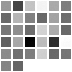

In [147]:
itorch.image(filterWeights)

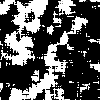

In [148]:
itorch.image(visLayerClone)

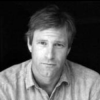

In [109]:
itorch.image(visLayer)

In [29]:
bla =visLayerClone:add(0):div(1)

In [57]:
filterWeights[1]:size()


  1
 10
 10
[torch.LongStorage of size 3]



In [149]:
bla = torch.Tensor(filterWeights:size())

In [150]:
for i = 1,filterWeights:size()[1] do
    bla[i] = image.minmax{tensor = filterWeights[i]}
end

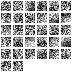

In [151]:
itorch.image(bla)

In [152]:
bla2 =image.minmax{tensor = visLayerClone}

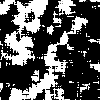

In [153]:
itorch.image(bla2)

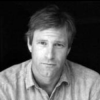

In [115]:
itorch.image(visLayer)

In [130]:
doobydoo = filterWeights[1]

In [154]:
visLayerClone

(1,.,.) = 
 Columns 1 to 9
  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.7914  0.3736  1.0000  1.0000  1.0000  1.0000
  1.0000  0.0000  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.6702  0.2741  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000
  1.0000  1.0000  1.0000

00  1.0000  0.0000
  0.0000  0.6546  1.0000  0.0000  1.0000  0.1898  1.0000  1.0000  1.0000
  0.0000  1.0000  0.0000  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  1.0000  0.0000  0.0000  0.0000  0.3806  0.4509  1.0000  0.0000
  0.7221  1.0000  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000
  0.8261  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000

0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  1.0000  0.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  1.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.9896  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  1.0000  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0456  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.7738  1.0000  1.0000
  0.0000  0.0000  0.00

0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.00

1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.2295  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.7041  1.0000
  0.0000  0.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  1.0000
  0.0000  1.0000  1.0000  1.0000  0.2044  0.1428  0.0000  0.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.7081
  0.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.8169  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  1.0000
  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  1.0000  0.0000  0.0000  1.0000  1.0000  0.0000  1.0000
  0.0000  0.0000  1.

0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.5752
  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  1.0000  1.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  0.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  0.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.

  0.0000  0.0000  0.0000  0.0000
  0.8687  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  0.9309  1.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.8397  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  1.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.7299  0.0000  0.0000
  0.8414  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.7389  1.0000  0.0000  0.0000  0.0000
  0.0000  0.3787  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  

  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  0.8970  1.0000  0.0862  1.0000  1.0000  0.6913  1.0000  0.3096
  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  0.0000  0.0000  0.0000

Columns 37 to 45
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000

00  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.8270  0.0000  1.0000
  0.0000  1.0000  0.0295  1.0000  0.0000  1.0000  1.0000  0.0000  1.0000
  0.0000  0.0000  0.0000  1.0000  0.0000  1.0000  1.0000  0.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000

0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.3269
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.00

0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.9645  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  1.0000  0.4471  0.0000
  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  1.0000  0.0000  0.0000
  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  1.0000  0.3143  0.1837
  1.0000  1.00

0.0000  0.0000  0.5592  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  0.0000  1.0000  0.0000  0.0000  0.5118
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.5802  0.0000
  1.0000  1.0000  1.0000  1.0000  0.0000  1.0000  1.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  0.5186  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  0.0000  0.0000
  0.0000  0.7861  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.

1.0000  0.4698  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.3834
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  1.0000  1.0000  1.0000  0.6246  0.0000  0.0000  0.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.7580
  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  1.0000  0.1779  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.

  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.7294
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000
  0.0000  1.0000  1.0000  0.0000  0.2591  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  0.2074  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  0.5463  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  0.9189  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000
  

  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  

00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0057  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000


00  0.0000  1.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  1.0000

Columns 82 to 90
  1.0000  1.0000  1.0000  1.0000  0.9164  0.0000  0.0000  0.0000  0.1822
  1.0000  1.0000  0.0000  0.8330  0.0000  0.1408  0.1137  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000

0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  1.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.2025  1.0000  0.2113  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.6632  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.2622  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000

0.0000  1.0000  0.3949  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0

0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.6429  1.0000  0.4318  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0985  0.0000  0.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0

In [135]:
torch.ge(doobydoo,250)

(1,.,.) = 
  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 